In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
from sklearn.metrics import silhouette_score


In [4]:
from os import listdir

path = "./Images/"
image_dir = [file for file in listdir(path)]

# Présentation du projet

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

logo entreprise place de marché
Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

Voici le mail qu’elle vous a envoyé.

 

Bonjour, 

Merci pour ton aide sur ce projet !

Ta mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pourrais-tu nous démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
une approche de type word/sentence embedding avec BERT ;
une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
un algorithme de type SIFT / ORB / SURF ;
un algorithme de type CNN Transfer Learning.
Merci encore, 

Le Notebook est organisé de la miniere suivante 

- Inspection des données
- Extraction de Features texte
- Extraction de features image
- Resultat final et conclusion

# Filtrage des données

In [5]:
path ="./"
data_T = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")

In [6]:
data_T

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [7]:
data_T.shape

(1050, 15)

On vérifie que les images du fichier sont les mêmes que celle indiqué dans le DataFrame 

In [8]:

image_dir.sort()==list(data_T['image']).sort()

True

On vérifie qu'aucune id de produit n'as été dupliqué 

In [9]:
data_T['uniq_id'].duplicated().sum()

0

On assemble les textes des colonnes "product name" et "description", les deux apportant des informations

In [10]:
data_T['product_name']=data_T['product_name']+data_T['description']

In [11]:
data_T['product_name']

0       Elegance Polyester Multicolor Abstract Eyelet ...
1       Sathiyas Cotton Bath TowelSpecifications of Sa...
2       Eurospa Cotton Terry Face Towel SetKey Feature...
3       SANTOSH ROYAL FASHION Cotton Printed King size...
4       Jaipur Print Cotton Floral King sized Double B...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker StickerWallmant...
1047    Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048    Wallmantra Medium Vinyl Sticker StickerBuy Wal...
1049    Uberlyfe Large Vinyl StickerBuy Uberlyfe Large...
Name: product_name, Length: 1050, dtype: object

Les catégories de produit sont représentées sous forme hiérarchique, on va donc les séparer et garder seulement les catégories principales

In [12]:
categorie=data_T['product_category_tree'].str.replace('[', ' ').str.replace('"', ' ').str.split(">>",expand=True)

C:\Users\pon\AppData\Local\Temp\ipykernel_19368\480150028.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  categorie=data_T['product_category_tree'].str.replace('[', ' ').str.replace('"', ' ').str.split(">>",expand=True)


In [13]:
data_T['product_category']=categorie[0]

In [14]:
data_T[['product_category_tree','product_category']]

,product_category_tree,product_category
0,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care


In [15]:
data_T['product_category'].value_counts()

  Home Furnishing                150
  Baby Care                      150
  Watches                        150
  Home Decor & Festive Needs     150
  Kitchen & Dining               150
  Beauty and Personal Care       150
  Computers                      150
Name: product_category, dtype: int64

On obtient 7 catégories , toutes equitablement réparties

In [16]:
data_T.to_csv('Data.csv',sep='\t',index=False)

# Extaction de Feature

Nous allons essayer différents modèles d'extraction de features (Texte et Image) auxquels nous aplliqueront une réduction de dimension Tsne , puis un clustering Kmean afin de pouvoir évaluer l"éfficacité de ces méthode

Une reduction PCA permet dans certain cas d'ameliorer les capicité de clustering du tsne , il est présent dans le notebook pour les modeles sur lesquels il s'est montré efficace

Pour cela nous utiliserons troix métriques:
- L'adjusted random score(ARI) : a valeurs dans [-1:1] qui indiquera la performance de la segmentation kmean
- Le silouhette score : compris entre -1 et 1 qui permet d'evaluer la capacité du Tsne a séparer les différentes catégories
- L'indice de Calinsky Harabasz : compris entre 0 et +ꝏ  qui permet d'évaluer du Tsne a concentrer chaque catégorie

## Extraction de feature Texte

Pour l'extraction de features texte nous testerons 5 modèles

Deux modèles de type bag of words:
- Countvectorizer
- TfidfVectoriez

Un modèle de Word embeding :
- Word2Vec

Deux reseaux de neurones :
- Bert uncase avec des poids entrainés provenant de HuggingFace
- Uniseversal sentence encoder avec des point entrainsé provenant de Tfhub

On utilisera des poids préentrainer pour nos réseau de neurones afin de grandement les temps de traitement du modèle

### Préparation du dataset

In [17]:
#tokeniezer
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('.',' ').replace(',',' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', ':', '?', '(', ')','inch','cm']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


data_T['sentence_bow_lem'] = data_T['product_name'].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T['product_name'].apply(lambda x : transform_dl_fct(x))
data_T.shape

(1050, 18)

Dans un premier temps , nous allons regarder les textes obtenue avec le preprocessing pour le bag of word, pour nous ajouterons aux stopwords tout les mots présents ayant une trop faible occurence, afin d'ameliorer les performances de nos modèles.



In [18]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())

max length bow :  381


In [19]:

def word_count(Ser):
    counts = dict()
    words = Ser

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts


full_str=[]
for i in range(0,len(data_T)):
    full_str=full_str+tokenizer_fct(data_T['sentence_bow_lem'][i])

test=word_count(full_str)

x=dict(sorted(test.items(), key=lambda item: item[1],reverse=True))
x_keys=list(dict(sorted(test.items(), key=lambda item: item[1],reverse=True)).keys())
x_values=list(dict(sorted(test.items(), key=lambda item: item[1],reverse=True)).values())

stop_df=pd.DataFrame({'keys': x_keys, 'occurence': x_values})





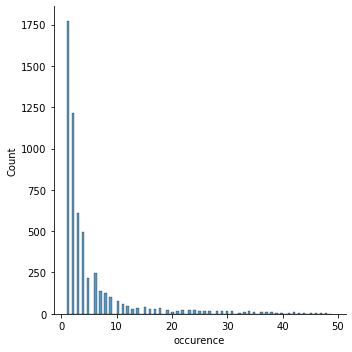

In [20]:

sns.displot(stop_df['occurence'][(stop_df['occurence']<50) ])

On va ajouter aux stopwords tous les mots ayant une occurence inférieur à 15

In [21]:
stop_occu=stop_df[stop_df['occurence']<15]['keys'].copy()

In [22]:
stop_w =stop_w+list(stop_occu)

On applique applique les fonctions de préparations du textes

In [23]:

data_T['sentence_bow_lem'] = data_T['product_name'].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T['product_name'].apply(lambda x : transform_dl_fct(x))
data_T.shape

data_T['length_bow'] = data_T['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())

max length bow :  306
max length dl :  603


On encode nos catégories

In [24]:
l_cat = list(set(data_T['product_category']))
print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(data_T.iloc[i]['product_category'])) for i in range(len(data_T))]

catégories :  ['  Home Decor & Festive Needs ', '  Beauty and Personal Care ', '  Home Furnishing ', '  Baby Care ', '  Kitchen & Dining ', '  Watches ', '  Computers ']


In [25]:
y_cat_num

[2,
 3,
 3,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 2,
 2,
 0,
 4,
 4,
 2,
 3,
 2,
 3,
 1,
 4,
 4,
 4,
 6,
 4,
 1,
 4,
 6,
 4,
 6,
 6,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 4,
 2,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 3,
 0,
 0,
 3,
 3,
 0,
 0,
 4,
 6,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 0,
 3,
 4,
 3,
 6,
 0,
 3,
 0,
 6,
 2,
 3,
 6,
 0,
 1,
 1,
 1,
 1,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 3,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 4,
 0,
 3,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,


# Bag of word

On applique les deux modèles de Bag of Words : 
   - CountVectorize
   - TfidfVectorizer
sur les données préparé

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words=stop_w, max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words=stop_w, max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['09', '10', '100', '14001', '16', '2004', '20mm', '22mm', '30', '40', 'art', 'boysd', 'capacity', 'content', 'cor', 'depth', 'dimension', 'length', 'material', 'package', 'pegs', 'pipes', 'qur', 'repouss', 'signer', 'size', 'smart', 'thnkss', 'width', 'x6'] not in stop_words.
  warnings.warn(


In [27]:
import time
from sklearn.metrics import calinski_harabasz_score


# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    SIL=silhouette_score(X_tsne, y_cat_num)
    CAL=calinski_harabasz_score(X_tsne, y_cat_num)
    metrique=[]
    metrique=[ARI,SIL,CAL]
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    print("silhouette : " , SIL)
    print("calinski : " , CAL)
    
    
    return ARI, X_tsne, cls.labels_, metrique


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)
    
#Calcul du la matrice de Confusion
def conf_mat_transform(y_true,y_pred,diagonal=True) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    print ("Correspondance des clusters : ", corresp)

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    if diagonal==True:
        labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    else :
        labels['y_pred_transform'] = labels['y_pred']
    
    return labels['y_pred_transform']

#Affichage de la matrice de Confusion
def confusion(labels,diag=True):

    conf_mat = metrics.confusion_matrix(y_cat_num, labels)

    cls_labels_transform = conf_mat_transform(y_cat_num, labels,diag)
    conf_mat = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
    print(conf_mat)
    print()
    print(metrics.classification_report(labels, cls_labels_transform))


    df_cm = pd.DataFrame(conf_mat, index = [label for label in set(labels)],
                      columns = [i for i in "0123456"])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

On affiche les résultats

CountVectorizer : 
-----------------


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4543 time :  13.0
silhouette :  0.23679695
calinski :  641.8350495411203


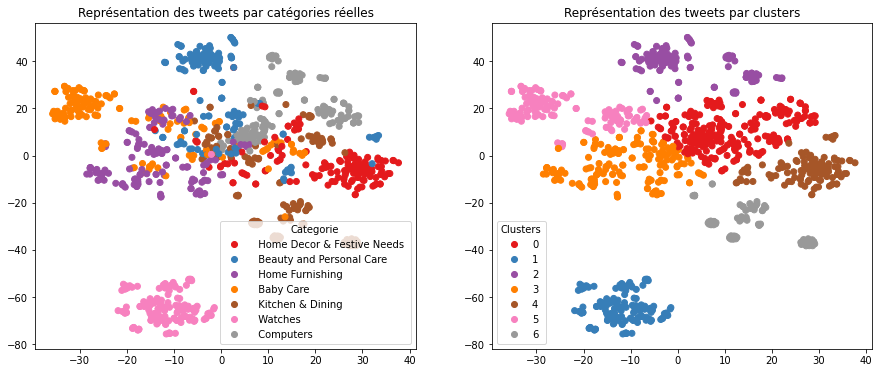

ARI :  0.4543


In [28]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels, met = ARI_fct(cv_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


La reduction de dimension avec Tsne pour ce modèle permet d'isoler la categorie "Watch", et une partie des catégories "baby care", "Beauty and personal Care" et "Kitchen & Dining"

En revanche une grande partie des données est difficilement differentiable

Correspondance des clusters :  [6 5 1 2 0 3 4]
[[ 99   3  16   1   2   0  29]
 [ 17  84  18   1   0   0  30]
 [  0   0 112  33   0   0   5]
 [  0   0  22 102   1   0  25]
 [  4   0  10   0  79   0  57]
 [  0   0   1   0   0 149   0]
 [  0  43   1   0   0   0 106]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     252.0
           1       0.00      0.00      0.00     149.0
           2       0.00      0.00      0.00     130.0
           3       0.00      0.00      0.00     180.0
           4       0.00      0.00      0.00     120.0
           5       0.00      0.00      0.00     137.0
           6       0.00      0.00      0.00      82.0

    accuracy                           0.00    1050.0
   macro avg       0.00      0.00      0.00    1050.0
weighted avg       0.00      0.00      0.00    1050.0



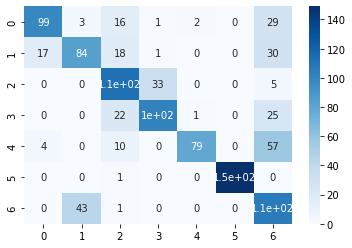

In [29]:
confusion(labels)

On peut remarquer que la segmentation est excellente pour la catégorie "watch" en revanche les autres catégories sont moin bien prédites , beaucoup de produit sont identifié comme "computer" et bien trop peu comme "Kitchen and dining"


Tf-idf : 
--------


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.6185 time :  12.0
silhouette :  0.29928467
calinski :  544.90572699808


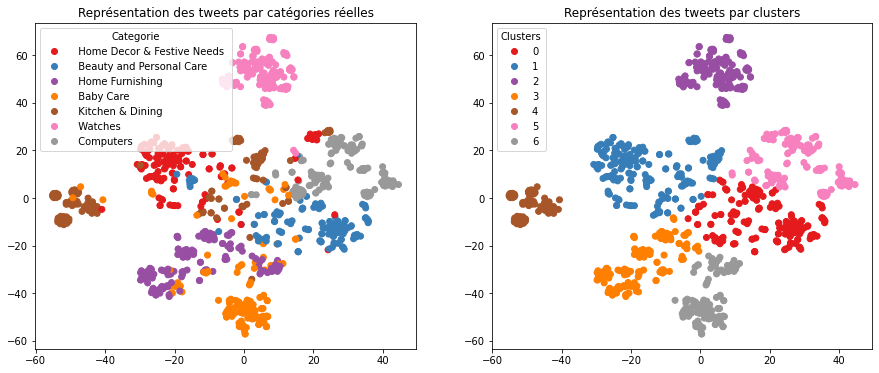

ARI :  0.6185


In [30]:
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels, met = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

La plupart des données sont isolées selon leur catégories cependant il reste un certaines données , appartenant notaments aux catégories :
- "kitchen and dining"
- "Baby Care"
- "Beauty and personal care"
- "Home furnishing"

qui ont du mal a etre differenciées par la réduction Tsne

Correspondance des clusters :  [1 0 5 2 4 6 3]
[[129   7   1   0   1   0  12]
 [ 11 136   1   0   0   0   2]
 [  0   0 129  21   0   0   0]
 [ 16  12  14 105   3   0   0]
 [ 55  11   1   1  74   0   8]
 [  0   0   0   0   0 148   2]
 [  0  28   0   0   0   0 122]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.00      0.00      0.00       211
           2       0.00      0.00      0.00       148
           3       0.00      0.00      0.00       146
           4       1.00      1.00      1.00        78
           5       0.00      0.00      0.00       146
           6       0.00      0.00      0.00       127

    accuracy                           0.07      1050
   macro avg       0.14      0.14      0.14      1050
weighted avg       0.07      0.07      0.07      1050



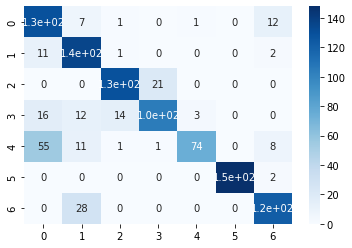

In [31]:
confusion(labels)

On a des meilleur résultats pour chaque cluster , cependant beaucoup de produit de catégories "kitchen and dining" sont prédit dans la catégorie "home décor and festive need"

# Wordtovect

In [32]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [33]:
data_T['sentence_bow_lem'].map(lambda x: len(x)).max()

2101

In [34]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 21 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

Création et entraînement du modèle Word2Vec

In [35]:


print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3876
Word2Vec trained


Préparation des sentences (tokenization)

In [36]:


print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3877


Création de la matrice d'embedding

In [37]:


print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3877, 300)


Création du modèle

In [38]:


input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 300)           1163100   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,163,100
Trainable params: 1,163,100
Non-trainable params: 0
_________________________________________________________________


In [39]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 719us/step


(1050, 300)

Affichage des résultats

In [40]:
ARI, X_tsne, labels, met = ARI_fct(embeddings)

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.2176 time :  15.0
silhouette :  0.06409976
calinski :  110.31870627342929


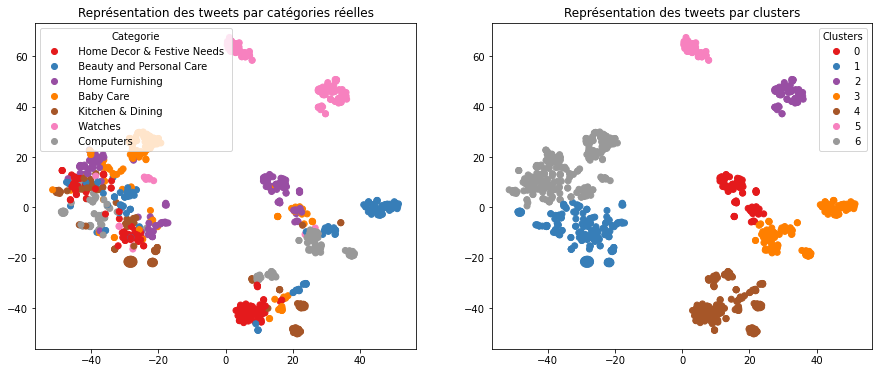

ARI :  0.2176


In [41]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Les résultat sont plutot mauvais les clusters obtenue après reduction ne correspondent pas du tout au cluster réels

Correspondance des clusters :  [2 4 5 1 0 5 3]
[[  0  36   0   0  76   0  38]
 [  0  15   0  80  21   0  34]
 [ 74  30   0   0   0   0  46]
 [ 21  10   0   4  14   0 101]
 [  0  65   0   3  48   0  34]
 [  0   5  79   2   0  53  11]
 [  0  45   0  70  24   0  11]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       206
           2       1.00      1.00      1.00        79
           3       1.00      1.00      1.00       159
           4       1.00      1.00      1.00       183
           5       1.00      1.00      1.00        53
           6       1.00      1.00      1.00       275

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050



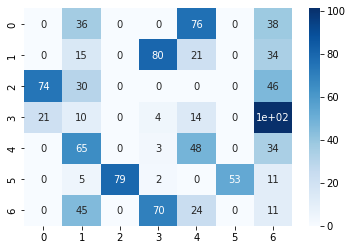

In [42]:
confusion(labels,False)

Beaucoup de données sont mal prédites , il devient difficile d'associer les segments predits aux segments reels

# BERT

In [43]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [44]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [45]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [46]:
max_length = 34
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\pon/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-unc

Création des features

In [47]:


features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\pon/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/res

1/1 [==============================] - 0s 294ms/step
temps traitement :  42.0


Affichage des résultats

In [48]:
ARI, X_tsne, labels, met = ARI_fct(features_bert)

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4643 time :  16.0
silhouette :  0.23036507
calinski :  391.0582804200999


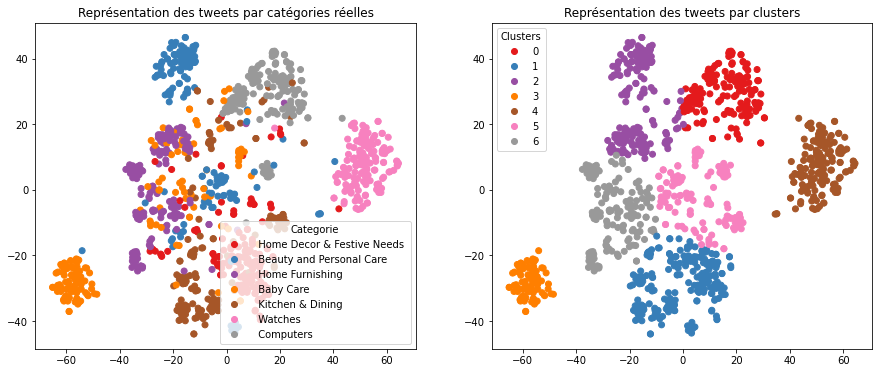

ARI :  0.4643


In [49]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Le modèle arrive très bien a isoler certaines catégories comme
- "Watches"
- "computers"

Cependant on grand nombre de données reste centrées et difficilement differentible sur la projection

Correspondance des clusters :  [6 0 1 3 5 1 2]
[[  4 101   2   0   1  27  15]
 [  3   9  82   1   4  41  10]
 [  2   2  45   0   0   3  98]
 [  2   4  24  79   0  17  24]
 [ 13  93  15   0   0  22   7]
 [  1   0   0   0 149   0   0]
 [132   0   3   0   1  14   0]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       209
           2       1.00      1.00      1.00       171
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00       155
           5       1.00      1.00      1.00       124
           6       1.00      1.00      1.00       154

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050



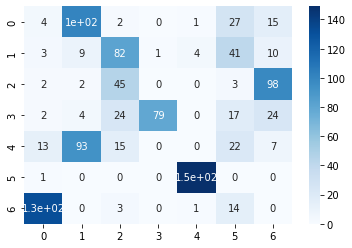

In [50]:
confusion(labels,False)

Bien que certaine categories soit très bien prédites les reste a des mauvaise prédiction , notament pour les produit des catégories  "Beauty and personal Care" et "Baby Care"

# USE

In [51]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [52]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [53]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [54]:
#Fonction des création des features
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [55]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

Créations des features

In [56]:
features_USE = feature_USE_fct(sentences, batch_size)

Affichage des résultats

In [57]:
ARI, X_tsne, labels, met = ARI_fct(features_USE)

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4116 time :  16.0
silhouette :  0.2323897
calinski :  448.79062384335856


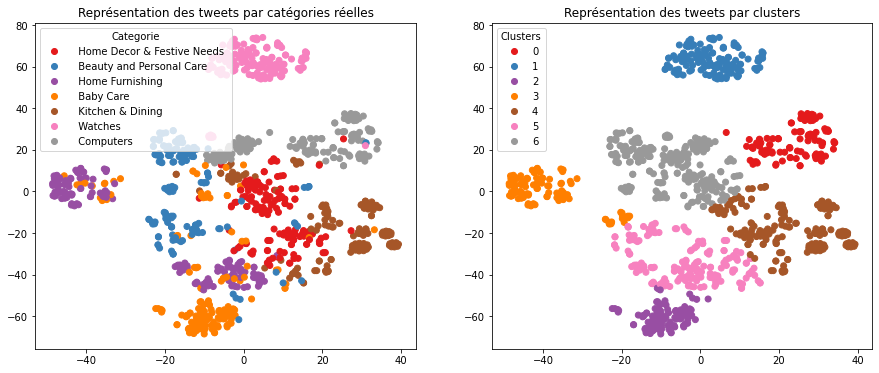

ARI :  0.4116


In [58]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


La catégories: "Watch" est bien isolée
En revanche une grande partie des données appartenant aux autres catégories se superposent sur la projection

Correspondance des clusters :  [6 5 3 2 4 2 1]
[[  2   0   0   0  64  29  55]
 [  2   0   4  17   7  39  81]
 [  0   0   2  74   0  74   0]
 [  0   0  91  17   2  23  17]
 [  7   0   0   0 111  10  22]
 [  1 143   0   0   0   0   6]
 [100   0   0   0   0   0  50]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00       143
           2       1.00      1.00      1.00        97
           3       1.00      1.00      1.00       108
           4       1.00      1.00      1.00       184
           5       1.00      1.00      1.00       175
           6       1.00      1.00      1.00       231

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050



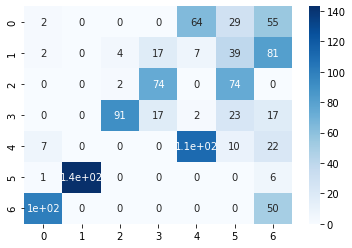

In [59]:
confusion(labels,False)

La catégories "Watch" est très bien prédite , en revanche la segmentation des autres catégories a des resultats moyens voir faible.

# Image

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
%matplotlib inline
from os import listdir

from sklearn import preprocessing

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

path = "./Images/"



1050


In [61]:
data=data_T.copy()

In [62]:


list_photos=data['image']

Exemple d'image et de leur catégories

  Home Furnishing 


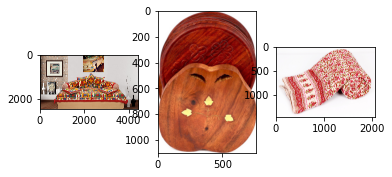

  Baby Care 


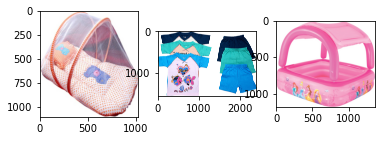

  Watches 


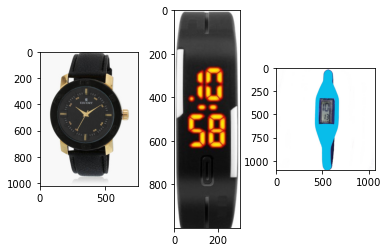

  Home Decor & Festive Needs 


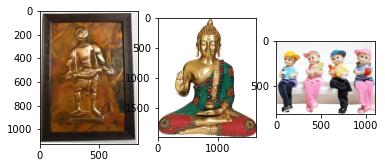

  Kitchen & Dining 


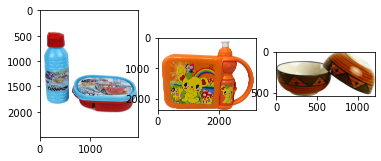

  Beauty and Personal Care 


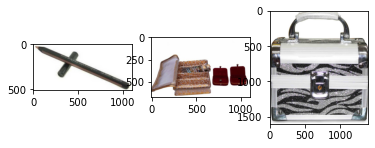

  Computers 


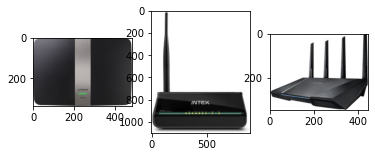

In [63]:
from matplotlib.image import imread

def list_fct(cat) :
    list_image_cat = data[data['product_category'].str.contains(cat)]['image']
    return list_image_cat

for name in data['product_category'].unique() :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name).to_list()[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

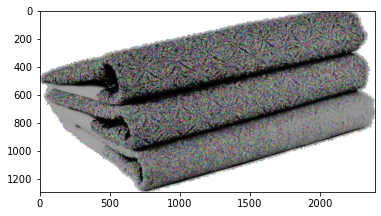

Descripteurs :  (47651, 128)

[[ 85. 113.  31. ...   0.   0.   0.]
 [ 29.  80.  73. ...   0.   0.   0.]
 [ 10.  67. 115. ...   0.   0.  22.]
 ...
 [  0.   0.   0. ...   0.   0.  13.]
 [ 40.   0.   0. ...   0.   0.  51.]
 [ 37.   1.   0. ...   0.   0.   0.]]


In [64]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

# Extraction de feature Image

Pour l'extraction de feature image nous allons tester 3 methodes:
 - Une extraction de features avec SIFT
 - Un réseau de neurone : Resnet50 en transfer Learning
 - Un réseau de neurone : VGG16 en transfer Learning

In [65]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    
    print ("Correspondance des clusters : ", corresp)

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']
    
def confusion(labels):

    
    
    y_cat = le.fit_transform(labels)
    cls_labels_transform = conf_mat_transform(y_cat, cls.labels_)
    conf_mat = metrics.confusion_matrix(y_cat, cls_labels_transform)
    print(conf_mat)
    print()
    print(metrics.classification_report(y_cat, cls_labels_transform))


    df_cm = pd.DataFrame(conf_mat, index = [label for label in set(y_cat)],
                      columns = [i for i in "0123456"])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

# SIFT

Créations des descripteurs de chaque image

Pour chaque image passage en gris et equalisation

Création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image

Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [66]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\pon\AppData\Local\Temp\ipykernel_19368\1752111521.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           359.67 secondes


Création des clusters image

In [67]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :             9.27 secondes


Création des features des images

Pour chaque image :
- prédiction des numéros de cluster de chaque descripteur
- création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
- Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [68]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :           113.30 secondes


Réduction de dimension PCA

In [69]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 290)


Réduction avec Tsne et affichage des resultats

In [70]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=50, 
                     n_iter=4000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data['product_category']
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


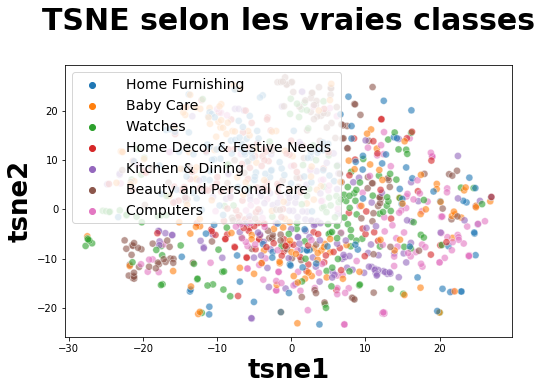

In [71]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Les résultats de la projection sont très mauvais , les catégories ne sont pas ddu tout différencier.
Le modèle SIFT n'est pas adapté a ce type de classification

In [72]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


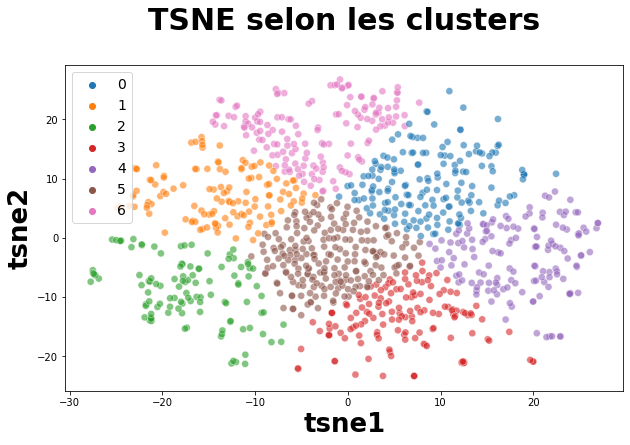

ARI :  0.03604929535791222
Silouhette :  -0.10488311
calinsky :  11.966883479697827


In [73]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data['product_category']

print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("Silouhette : ", silhouette_score(X_tsne, labels))
print("calinsky : ", calinski_harabasz_score(X_tsne, labels))

Correspondance des clusters :  [1 4 6 5 2 3 0]
[[34 16 21 24 22 22 11]
 [31 32 13 20 13 10 31]
 [ 7 23 48 26  5 34  7]
 [26 16 11 52 29 10  6]
 [29 30 19 15 36 13  8]
 [10 17 15 47 12 37 12]
 [11 32 19 25  7 20 36]]

              precision    recall  f1-score   support

           0       0.23      0.23      0.23       150
           1       0.19      0.21      0.20       150
           2       0.33      0.32      0.32       150
           3       0.25      0.35      0.29       150
           4       0.29      0.24      0.26       150
           5       0.25      0.25      0.25       150
           6       0.32      0.24      0.28       150

    accuracy                           0.26      1050
   macro avg       0.27      0.26      0.26      1050
weighted avg       0.27      0.26      0.26      1050



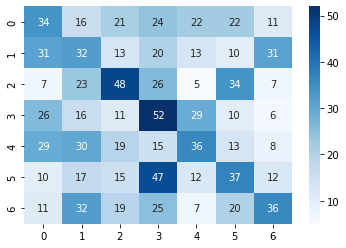

In [74]:
confusion(labels)

In [75]:
labels

0         Home Furnishing 
1               Baby Care 
2               Baby Care 
3         Home Furnishing 
4         Home Furnishing 
               ...        
1045            Baby Care 
1046            Baby Care 
1047            Baby Care 
1048            Baby Care 
1049            Baby Care 
Name: product_category, Length: 1050, dtype: object

# #Transfer Learning

Pour les modèles en transfer learning nous allons :
   - Telecharger le modèles et ses poids préentrainés
   - Replacer la couche Fully Connected par une couche identité
Puis pour chaque image nous allons :
   - Telecharger l'image
   - Applique le preprocessing relatif au modèles
   - Appliquer le modèle a l'image afin d'en extraire les features
   
Nous téléchargerons des poids préentrainé sur imagenet sur un grand nombre d'image  afin de réduire le temps de traitement et d'ameliorer les résultats du modèle.

### Resnet50

In [76]:
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm_notebook
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models import resnet50, ResNet50_Weights
import torch
import os
 
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model.fc = torch.nn.Identity()
model.eval()
train_nodes, eval_nodes = get_graph_node_names(resnet50())
 
transform = weights.transforms()
all_features = []
 
for i in tqdm_notebook(range(len(list_photos))):
    fullPath2img=os.path.join(path, list_photos[i])
    X_image = Image.open(fullPath2img)
    X = transform(X_image).unsqueeze(0)
    prediction = model(X)
    all_features.append(prediction.cpu().detach().numpy())
 
features = np.concatenate(all_features)

C:\Users\pon\AppData\Local\Temp\ipykernel_19368\2393781200.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(list_photos))):


  0%|          | 0/1050 [00:00<?, ?it/s]

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [77]:
features.shape

(1050, 2048)

In [78]:
im_features=features

In [79]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)


Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 555)


In [80]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=4000, init='random', random_state=4)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data['product_category']
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


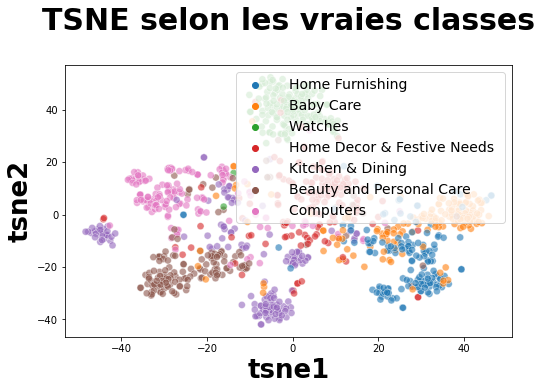

In [81]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Les Catégories sont assez bien séparées on peu cependant remarquer que le modèle a du mal a differencier les produit de type "Baby Care" au produits de type " Home furnishing"

De plus la catégories "Kitchen and Dining" est éclaté parmis toutes les autres données

In [82]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


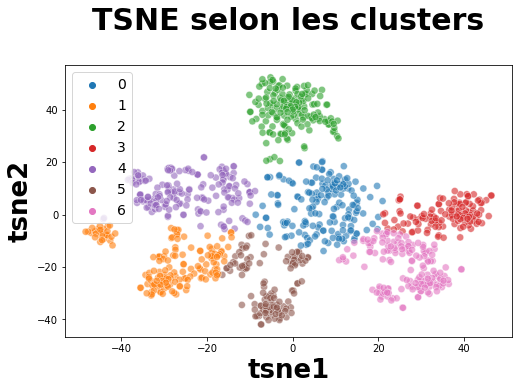

ARI :  0.5193467797605184
Silouhette :  0.22810538
calinsky :  427.3398659074442


In [83]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data['product_category']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("Silouhette : ", silhouette_score(X_tsne, labels))
print("calinsky : ", calinski_harabasz_score(X_tsne, labels))

In [84]:
features_image=features

Correspondance des clusters :  [3 1 6 0 2 5 4]
[[ 91   3   7  15  30   3   1]
 [  2 107  10  11   2  16   2]
 [  2   8 121  12   2   4   1]
 [  1   4   7 115   4  10   9]
 [ 24   0   3   8 113   2   0]
 [  0  35  22   8   0  84   1]
 [  0   0   2   0   0   0 148]]

              precision    recall  f1-score   support

           0       0.76      0.61      0.67       150
           1       0.68      0.71      0.70       150
           2       0.70      0.81      0.75       150
           3       0.68      0.77      0.72       150
           4       0.75      0.75      0.75       150
           5       0.71      0.56      0.62       150
           6       0.91      0.99      0.95       150

    accuracy                           0.74      1050
   macro avg       0.74      0.74      0.74      1050
weighted avg       0.74      0.74      0.74      1050



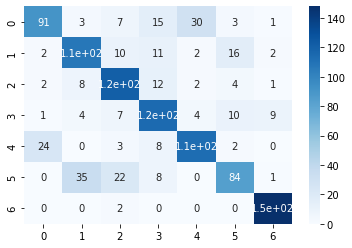

In [85]:
confusion(labels)

Les clusters sont assez bien prédits hormis pour :
- "Home Furnishing"
- "Beauty and personal Care"

# Vgg16

In [86]:
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm_notebook
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models import vgg16, VGG16_Weights
import torch
import os
 
weights = VGG16_Weights.IMAGENET1K_V1
model = vgg16(weights=weights)
model.fc = torch.nn.Identity()
model.eval()
train_nodes, eval_nodes = get_graph_node_names(resnet50())
 
transform = weights.transforms()
all_features = []
 
for i in tqdm_notebook(range(len(list_photos))):
    fullPath2img=os.path.join(path, list_photos[i])
    X_image = Image.open(fullPath2img)
    X = transform(X_image).unsqueeze(0)
    prediction = model(X)
    all_features.append(prediction.cpu().detach().numpy())
 
features = np.concatenate(all_features)

C:\Users\pon\AppData\Local\Temp\ipykernel_19368\2874654270.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(list_photos))):


  0%|          | 0/1050 [00:00<?, ?it/s]

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [87]:
features.shape

(1050, 1000)

In [88]:
im_features=features

Réduction PCA

In [89]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)


Dimensions dataset avant réduction PCA :  (1050, 1000)
Dimensions dataset après réduction PCA :  (1050, 194)


Réduction Tsne et affichage des résultats

In [90]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=4000, init='random', random_state=4)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data['product_category']
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


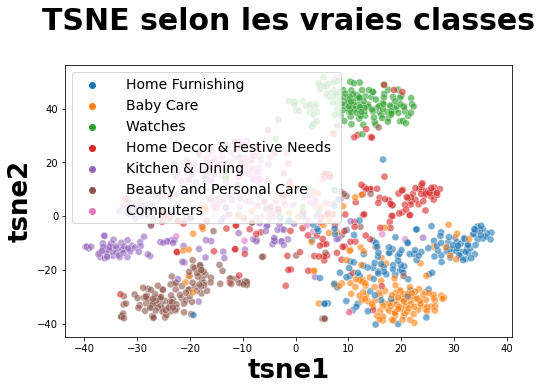

In [91]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Une partie de donnée arrivent a etre isoler celon leur catégories , cependant une grande partie se superposent au centre de la projection 

In [92]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


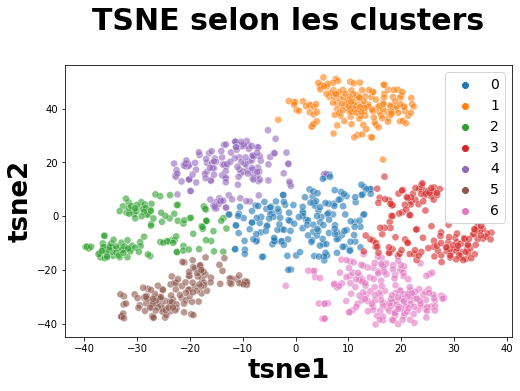

ARI :  0.47282165408504623
Silouhette :  0.20423952
calinsky :  454.10458038161164


In [93]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data['product_category']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("Silouhette : ", silhouette_score(X_tsne, labels))
print("calinsky : ", calinski_harabasz_score(X_tsne, labels))

Correspondance des clusters :  [3 6 5 4 2 1 0]
[[111   3   1  18   9   8   0]
 [  5 116   9  13   2   3   2]
 [  1   0 113  28   2   5   1]
 [  6   3   3  61  55  13   9]
 [ 53   1   0  17  78   0   1]
 [  1   6  14  31   1  97   0]
 [  0   0   4   3   0   0 143]]

              precision    recall  f1-score   support

           0       0.63      0.74      0.68       150
           1       0.90      0.77      0.83       150
           2       0.78      0.75      0.77       150
           3       0.36      0.41      0.38       150
           4       0.53      0.52      0.53       150
           5       0.77      0.65      0.70       150
           6       0.92      0.95      0.93       150

    accuracy                           0.68      1050
   macro avg       0.70      0.68      0.69      1050
weighted avg       0.70      0.68      0.69      1050



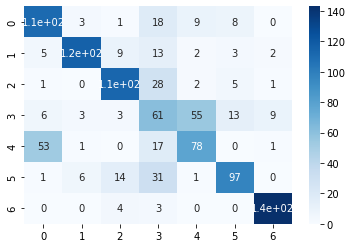

In [94]:
confusion(labels)

Les données des catégories 
- "Kitchen and Dining"
- "Beauty and personnal care"
sont très mal prédites

En revanche les prédictions des autres catégories ont une précision correcte

# Image + texte

Nous allons maintenant selectionner nous deux meilleur modèles puis concatener leurs features afin de pouvoir effectuer une réduction de dimension et un clustering plus performants

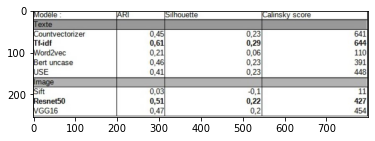

In [4]:
from matplotlib.image import imread
image = imread("tableau.jpg")
plt.imshow(image)

Pour l'extraction de features texte , le Tfidf est clairement donne les meilleurs résultats , ayant les plus haute valeurs sur toute les métriques.

Pour l'extraction de features Image, nous choisirons les features obtenue avec le modèle qui a la meilleur ARI : Le Resnet50

On peut cependant remarquer que les performances du modèles VGG16 sont proches de celle du Resnet50

On normalise les features obtenue puis on concatene les résultats

In [95]:
from sklearn.preprocessing import normalize
features_image=normalize(features_image)



In [96]:
from scipy.sparse import csr_matrix
features_texte=ctf_transform
features_texte=features_texte.todense()
features_texte=normalize(features_texte)

C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [97]:
features=np.concatenate((features_texte,features_image),1)

In [98]:
im_features=features

In [99]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)


Dimensions dataset avant réduction PCA :  (1050, 2754)
Dimensions dataset après réduction PCA :  (1050, 641)


In [100]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=4000, init='random', random_state=4)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data['product_category']
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


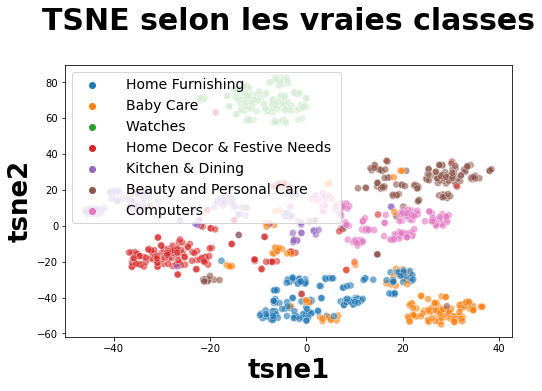

In [101]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Toutes les Catégories sont assez bien isolées a l'exception de quelque donnée qui se retrouvent au centre de la projection

In [102]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


C:\Users\pon\anaconda3\envs\gen2\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


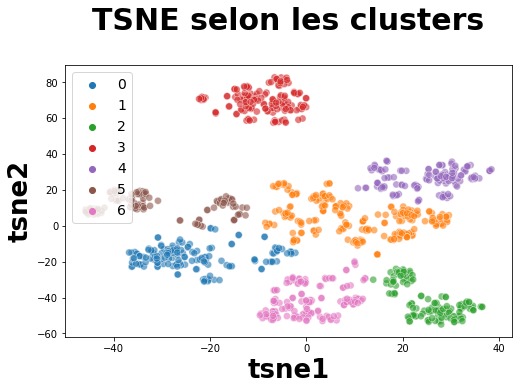

ARI :  0.6843576260253666
Silouhette :  0.3463484
calinsky :  803.6186898263177


In [103]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data['product_category']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("Silouhette : ", silhouette_score(X_tsne, labels))
print("calinsky : ", calinski_harabasz_score(X_tsne, labels))

Correspondance des clusters :  [3 2 0 6 1 5 4]
[[106   4   9  14  16   1   0]
 [  1 127   9  11   1   1   0]
 [  0   0 149   0   1   0   0]
 [  0   2  13 123   2   7   3]
 [ 26   0   0   1 123   0   0]
 [  0   0  38   2   0 110   0]
 [  0   0   0   0   0   0 150]]

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       150
           1       0.95      0.85      0.90       150
           2       0.68      0.99      0.81       150
           3       0.81      0.82      0.82       150
           4       0.86      0.82      0.84       150
           5       0.92      0.73      0.82       150
           6       0.98      1.00      0.99       150

    accuracy                           0.85      1050
   macro avg       0.86      0.85      0.85      1050
weighted avg       0.86      0.85      0.85      1050



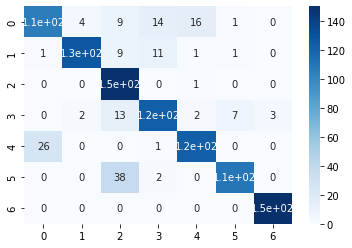

In [104]:
confusion(labels)

La plupart des Catégories sont très bien predites , on peux cependant constater que:
- Une partie de produits de la catégories "Home Furnishing" est prédit dans d'autres catégories
- Une partie des produits de la catégories "Kitchen and Dining" est prédite comme "Home furnishing"
- Une partie des produits de la catégories "Beauty and Personnal care" est prédite comme "Beauty Care"

# Conclusion

Les modèles d'extraction de features apportent des premier resultats concluant et les reduction tsne arrivent assez correctement a isoler les différentes catégories

Cependant certaines catégories étant très semblables : 
- "Beauty and Personnal care" et "Beauty Care"
- "Kitchen and Dining" et "Home furnishing"

il est difficile de les différencier , une réorganisation des catégories pourrait etre envisagable pour ameliorer les performances du modèle.

On pourra aussi tester d'autre méthode de segmentation , certaines directement sur les set de features afin d'ameliorer les résultats de la segmentation

Malgrès certaines limite, la classification automatique semble etre envisagable , surtout en remplacement d'une méthode manuelle jugé peu fiable